In [1]:
!pip install -q extinction==0.4.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.9/582.9 kB 9.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
train_df = pd.read_csv("/kaggle/input/mallorn-dataset/train_log.csv")
test_df = pd.read_csv("/kaggle/input/mallorn-dataset/test_log.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df['target'].value_counts())
print(f"\nImbalance ratio: {train_df['target'].value_counts()[0] / len(train_df):.2%} non-TDE")

Train shape: (3043, 8)
Test shape: (7135, 7)

Target distribution:
target
0    2895
1     148
Name: count, dtype: int64

Imbalance ratio: 95.14% non-TDE


In [4]:
train_df.head()

,object_id,Z,Z_err,EBV,SpecType,English Translation,split,target
0,Dornhoth_fervain_onodrim,3.0490,NaN,0.110,AGN,Trawn Folk (Dwarfs) + northern + Ents (people),split_01,0
1,Dornhoth_galadh_ylf,0.4324,NaN,0.058,SN II,Trawn Folk (Dwarfs) + tree + drinking vessel,split_01,0
2,Elrim_melethril_thul,0.4673,NaN,0.577,AGN,Elves + lover (fem.) + breath,split_01,0
3,Ithil_tobas_rodwen,0.6946,NaN,0.012,AGN,moon + roof + noble maiden,split_01,0
4,Mirion_adar_Druadan,0.4161,NaN,0.058,AGN,"jewel, Silmaril + father + Wild Man",split_01,0


In [ ]:
from extinction import fitzpatrick99

eff_wavelengths = {
    "u": 3641,
    "g": 4704,
    "r": 6155,
    "i": 7504,
    "z": 8695,
    "y": 10056
}

R_V = 3.1  # Fitzpatrick99 extinction law parameter

In [ ]:
def load_and_process_lightcurve(object_id, split, ebv, redshift, train_test="train"):
    lightcurves_path = f"/kaggle/input/mallorn-dataset/{split}/{train_test}_full_lightcurves.csv"
    lc_df = pd.read_csv(lightcurves_path)
    lc_df = lc_df[lc_df["object_id"] == object_id].copy()
    
    if lc_df.empty:
        return None
    
    # 1. Extinction correction
    A_lambda = lc_df["Filter"].map(
        lambda f: fitzpatrick99(np.array([eff_wavelengths[f]]), ebv * R_V)[0]
    )
    scale = 10 ** (A_lambda / 2.5)
    
    lc_df["Flux_true"] = lc_df["Flux"] * scale
    lc_df["Flux_err_true"] = lc_df["Flux_err"] * scale
    
    # 2. Time dilation correction (rest-frame time)
    # Time_rest = Time_obs / (1 + z)
    lc_df["Time_rest"] = lc_df["Time (MJD)"] / (1 + redshift)
    
    # Keep only necessary columns
    lc_df = lc_df[["object_id", "Time_rest", "Flux_true", "Flux_err_true", "Filter"]]
    
    return lc_df

In [7]:
# Process training data
print("Processing training lightcurves...")
train_lightcurves = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    lc = load_and_process_lightcurve(
        object_id=row["object_id"],
        split=row["split"],
        ebv=row["EBV"],
        redshift=row["Z"],
        train_test="train"
    )
    if lc is not None:
        train_lightcurves.append(lc)

# Concatenate all lightcurves
train_lc_df = pd.concat(train_lightcurves, ignore_index=True)
print(f"\nTrain lightcurves shape: {train_lc_df.shape}")
print(f"Unique objects: {train_lc_df['object_id'].nunique()}")

Processing training lightcurves...


100%|██████████| 3043/3043 [01:26<00:00, 35.05it/s]



Train lightcurves shape: (479384, 5)
Unique objects: 3043


In [8]:
# Process test data
print("Processing test lightcurves...")
test_lightcurves = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    lc = load_and_process_lightcurve(
        object_id=row["object_id"],
        split=row["split"],
        ebv=row["EBV"],
        redshift=row["Z"],
        train_test="test"
    )
    if lc is not None:
        test_lightcurves.append(lc)

# Concatenate all lightcurves
test_lc_df = pd.concat(test_lightcurves, ignore_index=True)
print(f"\nTest lightcurves shape: {test_lc_df.shape}")
print(f"Unique objects: {test_lc_df['object_id'].nunique()}")

Processing test lightcurves...


100%|██████████| 7135/7135 [06:48<00:00, 17.47it/s]



Test lightcurves shape: (1145125, 5)
Unique objects: 7135


In [9]:
train_lc_df.head(10)

,object_id,Time_rest,Flux_true,Flux_err_true,Filter
0,Dornhoth_fervain_onodrim,15637.062534,-1.895577,0.425332,z
1,Dornhoth_fervain_onodrim,15752.276463,13.652524,0.330108,r
2,Dornhoth_fervain_onodrim,15754.450309,6.595811,1.753158,y
3,Dornhoth_fervain_onodrim,15755.537219,5.075944,0.490030,r
4,Dornhoth_fervain_onodrim,15755.537219,6.340941,0.627057,i
5,Dornhoth_fervain_onodrim,15763.145690,1.443179,0.161080,g
6,Dornhoth_fervain_onodrim,15763.145690,1.930985,0.236045,r
7,Dornhoth_fervain_onodrim,15764.232625,0.276268,0.892838,u
8,Dornhoth_fervain_onodrim,15764.232625,1.538563,0.271010,r
9,Dornhoth_fervain_onodrim,15767.493381,0.880396,0.646890,i


In [ ]:
def compute_sequence_stats(lc_df, label="Train"):
    stats = []
    
    for obj_id in lc_df['object_id'].unique():
        obj_lc = lc_df[lc_df['object_id'] == obj_id]
        
        for filt in ['u', 'g', 'r', 'i', 'z', 'y']:
            filt_lc = obj_lc[obj_lc['Filter'] == filt]
            stats.append({
                'object_id': obj_id,
                'Filter': filt,
                'n_obs': len(filt_lc)
            })
    
    stats_df = pd.DataFrame(stats)
    
    # Group statistics by filter
    print(f"\n{'='*60}")
    print(f"Sequence Length Statistics - {label}")
    print(f"{'='*60}")
    
    for filt in ['u', 'g', 'r', 'i', 'z', 'y']:
        filt_stats = stats_df[stats_df['Filter'] == filt]['n_obs']
        print(f"\nFilter {filt}:")
        print(f"  Mean: {filt_stats.mean():.1f}")
        print(f"  Median: {filt_stats.median():.1f}")
        print(f"  Min: {filt_stats.min()}")
        print(f"  Max: {filt_stats.max()}")
        print(f"  Std: {filt_stats.std():.1f}")
        print(f"  25th percentile: {filt_stats.quantile(0.25):.1f}")
        print(f"  75th percentile: {filt_stats.quantile(0.75):.1f}")
        print(f"  95th percentile: {filt_stats.quantile(0.95):.1f}")
    
    return stats_df

In [11]:
# Compute statistics for training data
train_seq_stats = compute_sequence_stats(train_lc_df, label="Train")


Sequence Length Statistics - Train

Filter u:
  Mean: 13.7
  Median: 12.0
  Min: 0
  Max: 161
  Std: 15.9
  25th percentile: 9.0
  75th percentile: 14.0
  95th percentile: 20.0

Filter g:
  Mean: 16.2
  Median: 13.0
  Min: 0
  Max: 202
  Std: 19.0
  25th percentile: 11.0
  75th percentile: 17.0
  95th percentile: 23.0

Filter r:
  Mean: 36.4
  Median: 35.0
  Min: 5
  Max: 217
  Std: 20.3
  25th percentile: 28.0
  75th percentile: 40.0
  95th percentile: 49.0

Filter i:
  Mean: 36.3
  Median: 35.0
  Min: 4
  Max: 219
  Std: 19.6
  25th percentile: 29.0
  75th percentile: 40.0
  95th percentile: 48.0

Filter z:
  Mean: 32.0
  Median: 31.0
  Min: 2
  Max: 215
  Std: 20.2
  25th percentile: 25.0
  75th percentile: 36.0
  95th percentile: 43.0

Filter y:
  Mean: 23.1
  Median: 21.0
  Min: 0
  Max: 184
  Std: 17.1
  25th percentile: 17.0
  75th percentile: 26.0
  95th percentile: 32.0


In [13]:
# Compute statistics for test data
test_seq_stats = compute_sequence_stats(test_lc_df, label="Test")


Sequence Length Statistics - Test

Filter u:
  Mean: 14.0
  Median: 12.0
  Min: 0
  Max: 162
  Std: 17.5
  25th percentile: 9.0
  75th percentile: 14.0
  95th percentile: 20.0

Filter g:
  Mean: 16.6
  Median: 14.0
  Min: 0
  Max: 212
  Std: 20.9
  25th percentile: 11.0
  75th percentile: 17.0
  95th percentile: 24.0

Filter r:
  Mean: 36.8
  Median: 35.0
  Min: 4
  Max: 244
  Std: 22.3
  25th percentile: 29.0
  75th percentile: 40.0
  95th percentile: 48.0

Filter i:
  Mean: 36.6
  Median: 35.0
  Min: 3
  Max: 231
  Std: 21.2
  25th percentile: 29.0
  75th percentile: 40.0
  95th percentile: 48.0

Filter z:
  Mean: 32.8
  Median: 31.0
  Min: 2
  Max: 247
  Std: 22.3
  25th percentile: 25.0
  75th percentile: 36.0
  95th percentile: 44.0

Filter y:
  Mean: 23.7
  Median: 22.0
  Min: 0
  Max: 184
  Std: 18.4
  25th percentile: 17.0
  75th percentile: 26.0
  95th percentile: 32.0


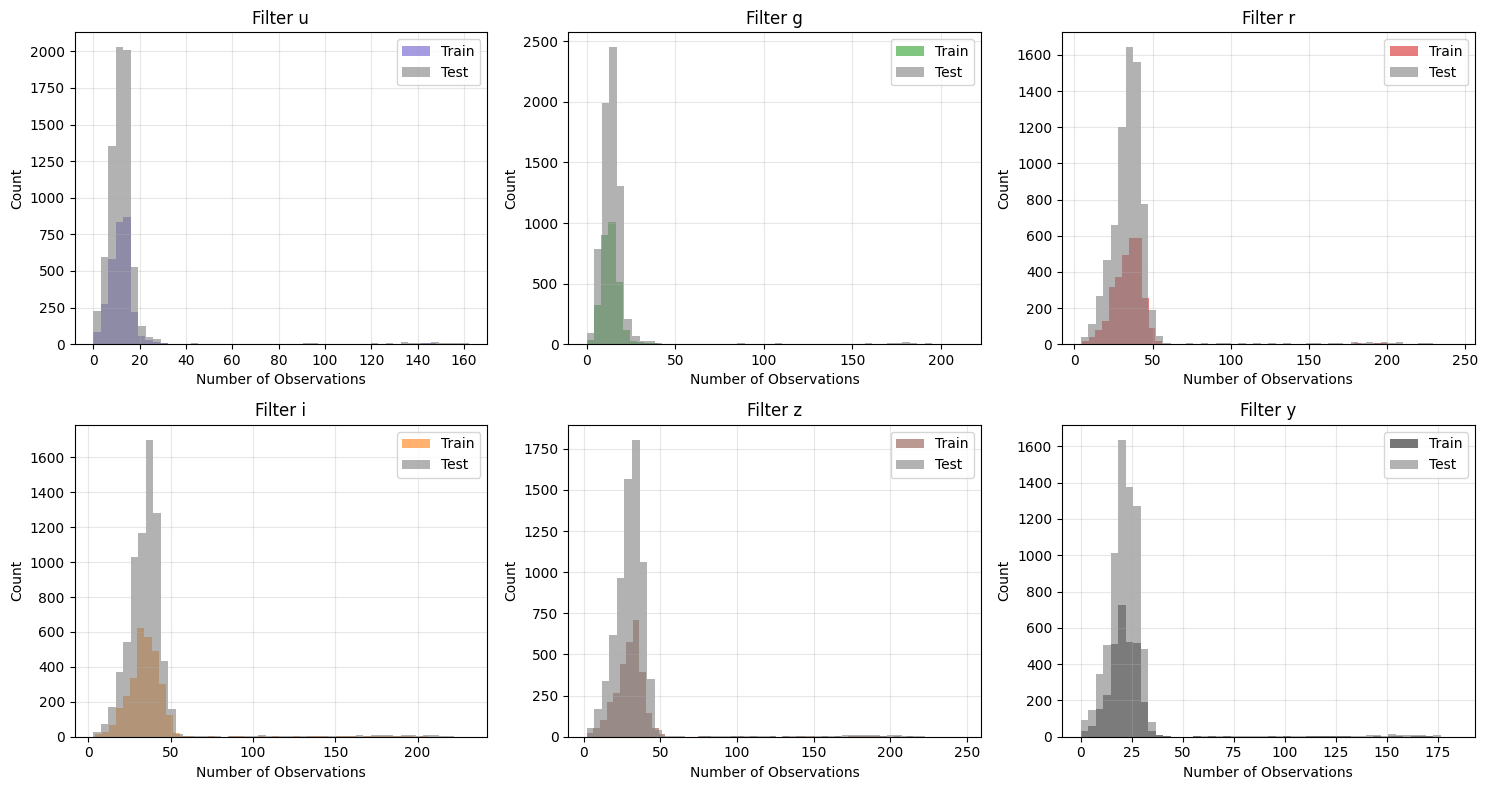

In [14]:
# Plot distribution of sequence lengths
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

filter_colours = {
    'u': '#6A5ACD',
    'g': '#2ca02c',
    'r': '#d62728',
    'i': '#ff7f0e',
    'z': '#8c564b',
    'y': '#1b1b1b'
}

for idx, filt in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    ax = axes[idx]
    
    # Get data for this filter
    train_data = train_seq_stats[train_seq_stats['Filter'] == filt]['n_obs']
    test_data = test_seq_stats[test_seq_stats['Filter'] == filt]['n_obs']
    
    # Plot histograms
    ax.hist(train_data, bins=50, alpha=0.6, label='Train', color=filter_colours[filt])
    ax.hist(test_data, bins=50, alpha=0.6, label='Test', color='gray')
    
    ax.set_xlabel('Number of Observations')
    ax.set_ylabel('Count')
    ax.set_title(f'Filter {filt}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Overall statistics across all bands
print("\n" + "="*60)
print("Overall Statistics (All Bands Combined)")
print("="*60)

print("\nTrain:")
print(f"  Total observations: {len(train_lc_df)}")
print(f"  Average per object per band: {train_seq_stats['n_obs'].mean():.1f}")
print(f"  Objects with < 10 obs in any band: {(train_seq_stats['n_obs'] < 10).sum()}")
print(f"  Objects with 0 obs in any band: {(train_seq_stats['n_obs'] == 0).sum()}")

print("\nTest:")
print(f"  Total observations: {len(test_lc_df)}")
print(f"  Average per object per band: {test_seq_stats['n_obs'].mean():.1f}")
print(f"  Objects with < 10 obs in any band: {(test_seq_stats['n_obs'] < 10).sum()}")
print(f"  Objects with 0 obs in any band: {(test_seq_stats['n_obs'] == 0).sum()}")


Overall Statistics (All Bands Combined)

Train:
  Total observations: 479384
  Average per object per band: 26.3
  Objects with < 10 obs in any band: 1718
  Objects with 0 obs in any band: 33

Test:
  Total observations: 1145125
  Average per object per band: 26.7
  Objects with < 10 obs in any band: 4057
  Objects with 0 obs in any band: 93


In [16]:
# Calculate recommended sequence length per filter
print("\n" + "="*60)
print("Recommended Sequence Lengths (95th percentile)")
print("="*60)

recommended_lengths = {}
for filt in ['u', 'g', 'r', 'i', 'z', 'y']:
    filt_stats = train_seq_stats[train_seq_stats['Filter'] == filt]['n_obs']
    rec_len = int(np.ceil(filt_stats.quantile(0.95)))
    recommended_lengths[filt] = rec_len
    print(f"Filter {filt}: {rec_len} time steps")

# Global recommendation (use same length for all filters for simplicity)
global_rec_length = int(np.ceil(train_seq_stats['n_obs'].quantile(0.95)))
print(f"\nGlobal recommendation (uniform): {global_rec_length} time steps")


Recommended Sequence Lengths (95th percentile)
Filter u: 20 time steps
Filter g: 23 time steps
Filter r: 49 time steps
Filter i: 48 time steps
Filter z: 43 time steps
Filter y: 32 time steps

Global recommendation (uniform): 45 time steps


In [11]:
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report

# Config
SEQ_LENGTH = 60  # Fixed sequence length
N_CHANNELS = 6   # 6 filters (u, g, r, i, z, y)
FILTERS = ['u', 'g', 'r', 'i', 'z', 'y']

In [ ]:
def interpolate_lightcurve(lc_df, object_id, seq_length=60):
    flux_seq = np.zeros((6, seq_length))
    mask = np.zeros((6, seq_length))
    
    obj_lc = lc_df[lc_df['object_id'] == object_id]
    
    if obj_lc.empty:
        return flux_seq, mask
    
    # Get global time range across all filters
    t_min = obj_lc['Time_rest'].min()
    t_max = obj_lc['Time_rest'].max()
    
    # Create uniform time grid
    if t_min == t_max:
        t_grid = np.array([t_min] * seq_length)
    else:
        t_grid = np.linspace(t_min, t_max, seq_length)
    
    for i, filt in enumerate(FILTERS):
        filt_lc = obj_lc[obj_lc['Filter'] == filt].sort_values('Time_rest')
        
        if len(filt_lc) == 0:
            # No data for this filter -> leave as zeros with mask=0
            continue
        
        if len(filt_lc) == 1:
            # Only 1 point -> constant interpolation
            flux_seq[i, :] = filt_lc['Flux_true'].values[0]
            mask[i, :] = 1
        else:
            # Linear interpolation
            t = filt_lc['Time_rest'].values
            f = filt_lc['Flux_true'].values
            
            # Handle extrapolation by filling with edge values
            interp_func = interp1d(t, f, kind='linear', bounds_error=False, 
                                   fill_value=(f[0], f[-1]))
            
            flux_seq[i, :] = interp_func(t_grid)
            mask[i, :] = 1
    
    return flux_seq, mask

In [13]:
# Prepare training data
print("Preparing training sequences...")
X_train_list = []
masks_train_list = []
y_train = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    flux_seq, mask = interpolate_lightcurve(train_lc_df, row['object_id'], SEQ_LENGTH)
    X_train_list.append(flux_seq)
    masks_train_list.append(mask)
    y_train.append(row['target'])

X_train = np.array(X_train_list)  # Shape: (n_samples, 6, 60)
masks_train = np.array(masks_train_list)
y_train = np.array(y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Class distribution: {np.bincount(y_train)}")

Preparing training sequences...


100%|██████████| 3043/3043 [02:13<00:00, 22.81it/s]

X_train shape: (3043, 6, 60)
y_train shape: (3043,)
Class distribution: [2895  148]


In [14]:
# Prepare test data
print("Preparing test sequences...")
X_test_list = []
masks_test_list = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    flux_seq, mask = interpolate_lightcurve(test_lc_df, row['object_id'], SEQ_LENGTH)
    X_test_list.append(flux_seq)
    masks_test_list.append(mask)

X_test = np.array(X_test_list)  # Shape: (n_samples, 6, 60)
masks_test = np.array(masks_test_list)

print(f"X_test shape: {X_test.shape}")

Preparing test sequences...


100%|██████████| 7135/7135 [11:18<00:00, 10.52it/s]


X_test shape: (7135, 6, 60)


In [15]:
def normalize_flux(X, masks):
    """
    Normalize flux per sample using masked mean and std.
    """
    X_norm = np.zeros_like(X)
    
    for i in range(len(X)):
        sample = X[i]  # Shape: (6, 60)
        mask = masks[i]
        
        # Compute mean and std only over valid (masked) values
        valid_flux = sample[mask == 1]
        
        if len(valid_flux) > 0:
            mean = valid_flux.mean()
            std = valid_flux.std()
            
            if std > 0:
                X_norm[i] = (sample - mean) / std
            else:
                X_norm[i] = sample - mean
        else:
            X_norm[i] = sample
    
    # Safety: Replace any NaN or Inf with 0
    X_norm = np.nan_to_num(X_norm, nan=0.0, posinf=0.0, neginf=0.0)
    
    return X_norm

X_train_norm = normalize_flux(X_train, masks_train)
X_test_norm = normalize_flux(X_test, masks_test)

print("Normalization complete!")
print(f"Train - NaN count: {np.isnan(X_train_norm).sum()}, Inf count: {np.isinf(X_train_norm).sum()}")
print(f"Test - NaN count: {np.isnan(X_test_norm).sum()}, Inf count: {np.isinf(X_test_norm).sum()}")

Normalization complete!
Train - NaN count: 0, Inf count: 0
Test - NaN count: 0, Inf count: 0


In [16]:
class LightcurveDataset(Dataset):
    def __init__(self, X, y, masks):
        self.X = torch.FloatTensor(X)  # (n, 6, 60)
        self.y = torch.FloatTensor(y)
        self.masks = torch.FloatTensor(masks)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.masks[idx]

In [17]:
class MultiChannelLSTM(nn.Module):
    def __init__(self, n_channels=6, seq_length=60, hidden_size=128, 
                 num_layers=2, dropout=0.3):
        super(MultiChannelLSTM, self).__init__()
        
        # Single LSTM for all channels (treat 6 channels as features)
        self.lstm = nn.LSTM(
            input_size=n_channels,  # 6 channels as input features
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x: (batch, 6, 60)
        # Transpose to (batch, 60, 6) - treat 6 channels as features
        x = x.transpose(1, 2)  # (batch, seq_length=60, n_channels=6)
        
        # LSTM forward
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use last hidden state: (batch, hidden_size)
        x = h_n[-1]
        
        # Dense layers
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        # No sigmoid here - BCEWithLogitsLoss will apply it
        
        return x.squeeze()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
N_EPOCHS = 50
N_FOLDS = 5

# Class weights for imbalance (95:5 ratio)
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
pos_weight = n_neg / n_pos
print(f"Positive class weight: {pos_weight:.2f}")

Using device: cuda
Positive class weight: 19.56


In [19]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch, masks_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate_model(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred_proba = []
    
    with torch.no_grad():
        for X_batch, y_batch, masks_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # Apply sigmoid to get probabilities (model outputs logits now)
            probs = torch.sigmoid(outputs)
            
            y_true.extend(y_batch.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred_proba)

In [20]:
# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

fold_scores = []
best_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_norm, y_train)):
    print(f"\n{'='*60}")
    print(f"Fold {fold + 1}/{N_FOLDS}")
    print(f"{'='*60}")
    
    # Split data
    X_train_fold = X_train_norm[train_idx]
    y_train_fold = y_train[train_idx]
    masks_train_fold = masks_train[train_idx]
    
    X_val_fold = X_train_norm[val_idx]
    y_val_fold = y_train[val_idx]
    masks_val_fold = masks_train[val_idx]
    
    # Create datasets
    train_dataset = LightcurveDataset(X_train_fold, y_train_fold, masks_train_fold)
    val_dataset = LightcurveDataset(X_val_fold, y_val_fold, masks_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize model
    model = MultiChannelLSTM(n_channels=6, seq_length=SEQ_LENGTH).to(device)
    
    # Loss with class weights (BCEWithLogitsLoss combines sigmoid + BCE, more stable)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    # Training loop
    best_f1 = 0
    best_threshold = 0.5
    patience = 10
    patience_counter = 0
    
    for epoch in range(N_EPOCHS):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        y_val_true, y_val_pred_proba = evaluate_model(model, val_loader, device)
        
        # Find best threshold for F1
        thresholds = np.linspace(0.1, 0.9, 50)
        f1_scores = []
        for thresh in thresholds:
            y_val_pred = (y_val_pred_proba >= thresh).astype(int)
            f1 = f1_score(y_val_true, y_val_pred)
            f1_scores.append(f1)
        
        best_idx = np.argmax(f1_scores)
        epoch_best_f1 = f1_scores[best_idx]
        epoch_best_thresh = thresholds[best_idx]
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{N_EPOCHS} - Loss: {train_loss:.4f}, "
                  f"Val F1: {epoch_best_f1:.4f} (thresh={epoch_best_thresh:.2f})")
        
        # Early stopping
        if epoch_best_f1 > best_f1:
            best_f1 = epoch_best_f1
            best_threshold = epoch_best_thresh
            patience_counter = 0
            # Save best model state
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    print(f"\nFold {fold+1} Best F1: {best_f1:.4f} (threshold={best_threshold:.2f})")
    fold_scores.append({'f1': best_f1, 'threshold': best_threshold})
    best_models.append(model)

# Average scores
avg_f1 = np.mean([s['f1'] for s in fold_scores])
avg_thresh = np.mean([s['threshold'] for s in fold_scores])
print(f"\n{'='*60}")
print(f"Average F1 across {N_FOLDS} folds: {avg_f1:.4f}")
print(f"Average threshold: {avg_thresh:.2f}")
print(f"{'='*60}")


Fold 1/5
Epoch 1/50 - Loss: 0.3406, Val F1: 0.0000 (thresh=0.10)
Epoch 6/50 - Loss: 0.1937, Val F1: 0.0000 (thresh=0.10)
Epoch 11/50 - Loss: 0.1784, Val F1: 0.3038 (thresh=0.10)
Epoch 16/50 - Loss: 0.2431, Val F1: 0.1905 (thresh=0.15)
Epoch 21/50 - Loss: 0.1938, Val F1: 0.2632 (thresh=0.10)
Early stopping at epoch 21

Fold 1 Best F1: 0.3038 (threshold=0.10)

Fold 2/5
Epoch 1/50 - Loss: 0.3888, Val F1: 0.0000 (thresh=0.10)
Epoch 6/50 - Loss: 0.2008, Val F1: 0.1136 (thresh=0.10)
Epoch 11/50 - Loss: 0.1930, Val F1: 0.0000 (thresh=0.10)
Epoch 16/50 - Loss: 0.1737, Val F1: 0.1622 (thresh=0.10)
Epoch 21/50 - Loss: 0.1617, Val F1: 0.1569 (thresh=0.15)
Epoch 26/50 - Loss: 0.1463, Val F1: 0.2000 (thresh=0.12)
Epoch 31/50 - Loss: 0.1329, Val F1: 0.2500 (thresh=0.36)
Epoch 36/50 - Loss: 0.1210, Val F1: 0.3294 (thresh=0.15)
Epoch 41/50 - Loss: 0.1037, Val F1: 0.3667 (thresh=0.26)
Epoch 46/50 - Loss: 0.0763, Val F1: 0.3133 (thresh=0.10)

Fold 2 Best F1: 0.3667 (threshold=0.26)

Fold 3/5
Epoch 1/50

In [21]:
# Create test dataset
test_dataset = LightcurveDataset(X_test_norm, np.zeros(len(X_test_norm)), masks_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Ensemble predictions from all folds
print("Generating test predictions...")
all_predictions = []

for fold, model in enumerate(best_models):
    model.eval()
    fold_predictions = []
    
    with torch.no_grad():
        for X_batch, _, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # Apply sigmoid to get probabilities (model outputs logits now)
            probs = torch.sigmoid(outputs)
            fold_predictions.extend(probs.cpu().numpy())
    
    all_predictions.append(fold_predictions)
    print(f"Fold {fold+1} predictions complete")

# Average predictions across folds
avg_predictions = np.mean(all_predictions, axis=0)

print(f"\nPrediction stats:")
print(f"  Min: {avg_predictions.min():.4f}")
print(f"  Max: {avg_predictions.max():.4f}")

print(f"  Mean: {avg_predictions.mean():.4f}")
print(f"  Predictions > 0.5: {(avg_predictions > 0.5).sum()}")

Generating test predictions...
Fold 1 predictions complete
Fold 2 predictions complete
Fold 3 predictions complete
Fold 4 predictions complete
Fold 5 predictions complete

Prediction stats:
  Min: 0.0021
  Max: 0.5579
  Mean: 0.0545
  Predictions > 0.5: 25


In [24]:
# Create submission dataframe
submission = pd.DataFrame({
    'object_id': test_df['object_id'],
    'prediction': avg_predictions
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created!")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

print(f"\nSubmission shape: {submission.shape}")
print(f"Predicted TDEs (prob > 0.5): {(submission['prediction'] > 0.5).sum()}")
print(f"Predicted TDEs (prob > avg_thresh={avg_thresh:.2f}): {(submission['prediction'] > avg_thresh).sum()}")

Submission file created!

First 10 predictions:
                      object_id  prediction
0      Eluwaith_Mithrim_nothrim    0.019583
1            Eru_heledir_archam    0.019659
2             Gonhir_anann_fuin    0.006632
3  Gwathuirim_haradrim_tegilbor    0.103746
4              achas_minai_maen    0.045051
5                 adab_fae_gath    0.019133
6               adel_draug_gaur    0.061797
7       aderthad_cuil_galadhrim    0.130250
8           aegas_laug_ithildin    0.012837
9              aegas_mereth_law    0.067799

Submission shape: (7135, 2)
Predicted TDEs (prob > 0.5): 25
Predicted TDEs (prob > avg_thresh=0.29): 326


In [25]:
# Option 1: dùng ngưỡng 0.5
submission = pd.DataFrame({
    "object_id": test_df["object_id"].values,
    "prediction": (avg_predictions > 0.5).astype(int)
})

submission.to_csv("submission.csv", index=False)

print("Submission file created!")
print(submission.head(10))
print("Submission shape:", submission.shape)
print("Predicted TDEs (pred=1):", submission["prediction"].sum())


Submission file created!
                      object_id  prediction
0      Eluwaith_Mithrim_nothrim           0
1            Eru_heledir_archam           0
2             Gonhir_anann_fuin           0
3  Gwathuirim_haradrim_tegilbor           0
4              achas_minai_maen           0
5                 adab_fae_gath           0
6               adel_draug_gaur           0
7       aderthad_cuil_galadhrim           0
8           aegas_laug_ithildin           0
9              aegas_mereth_law           0
Submission shape: (7135, 2)
Predicted TDEs (pred=1): 25
